# Project: Walmart Sales Forecasting
**Phase IV: Model Evaluation**

@author: Syed Shahzad Raza

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-required-dependencies" data-toc-modified-id="Import-required-dependencies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import required dependencies</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Define-Model-Performance-Indicator" data-toc-modified-id="Define-Model-Performance-Indicator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Model Performance Indicator</a></span></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Evaluation</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Linear Regression</a></span><ul class="toc-item"><li><span><a href="#WMAE-for-Linear-Regression" data-toc-modified-id="WMAE-for-Linear-Regression-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>WMAE for Linear Regression</a></span></li></ul></li><li><span><a href="#Linear-Regression---TrainValidationSplit---hyper-parameter-tuning" data-toc-modified-id="Linear-Regression---TrainValidationSplit---hyper-parameter-tuning-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Linear Regression - TrainValidationSplit - hyper-parameter tuning</a></span><ul class="toc-item"><li><span><a href="#WMAE-for-TVS" data-toc-modified-id="WMAE-for-TVS-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>WMAE for TVS</a></span></li></ul></li><li><span><a href="#Generalized-Linear-Regression" data-toc-modified-id="Generalized-Linear-Regression-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Generalized Linear Regression</a></span><ul class="toc-item"><li><span><a href="#WMAE-for-Generalized-Linear-Regression" data-toc-modified-id="WMAE-for-Generalized-Linear-Regression-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>WMAE for Generalized Linear Regression</a></span></li></ul></li></ul></li><li><span><a href="#Comparing-WMAE" data-toc-modified-id="Comparing-WMAE-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Comparing WMAE</a></span></li></ul></div>

## Import required dependencies

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import exp, when
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession \
    .builder \
    .getOrCreate()

import pandas as pd
import numpy as np
import builtins

# import matplotlib for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# import seaborn for data visualization
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_palette('colorblind')

## Load Data

In [2]:
# Load data saved in phase III
train_df = spark.read.format("csv").option("header", "true").option('inferSchema', 'true').load("phase_3_train_df.csv")
validate_df = spark.read.format("csv").option("header", "true").option('inferSchema', 'true').load("phase_3_validate_df.csv")
test_df = spark.read.format("csv").option("header", "true").option('inferSchema', 'true').load("phase_3_test_df.csv")

## Define Model Performance Indicator
**Using criteria set by Walmart**

Models will be evaluated using weighted mean absolute error (WMAE) 

\begin{equation*}
WMAE = \frac{1}{\sum w_i} \sum_{i=1}^n w_i |y_i-\hat{y_i}|
\end{equation*}
where

* $n$ is the number of rows
* $\hat{y_i}$ is the predicted sales
* $y_i$ is the actual sales
* $w_i$ are weights. $w = 5$ if the week is a holiday week, $1$ otherwise

In [16]:
def WMAE(weights, real, predicted):
    return np.round(np.sum(weights*builtins.abs(real-predicted))/(np.sum(weights)), 2)

## Model Evaluation

### Linear Regression

In [17]:
# Load Linear Regression
LR_model = PipelineModel.load("LR_model")

In [18]:
LR_prediction = LR_model.transform(validate_df)

In [25]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

In [137]:
rmse_LR = evaluator.evaluate(LR_prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_LR)

Root Mean Squared Error (RMSE) on test data = 1.30177


In [27]:
LR_Predict_train2 = LR_prediction.select("Week","features","label","prediction").toPandas()

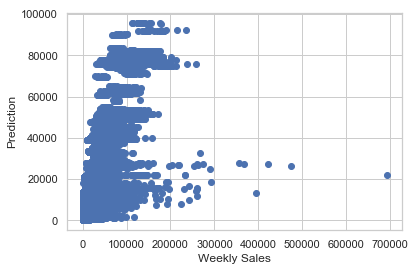

In [88]:
plt.plot(np.exp(LR_Predict_train2.label)-1, np.exp(LR_Predict_train2.prediction)-1, 'bo')
plt.xlabel('Weekly Sales')
plt.ylabel('Prediction')
plt.show()

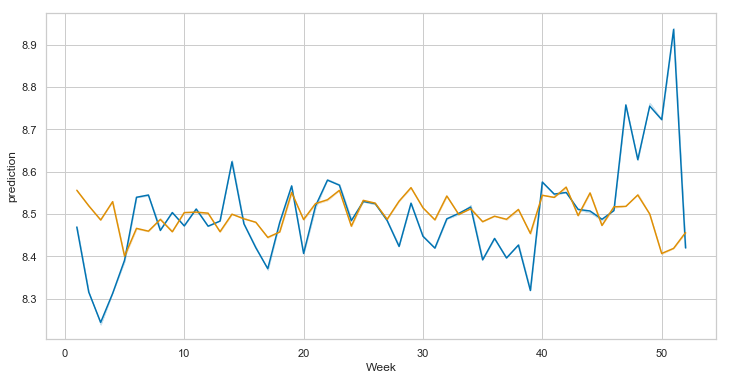

In [31]:
plt.figure(figsize=(12,6))
sns.lineplot(x = "Week", y = "label", data = LR_Predict_train2, ci=False)
sns.lineplot(x = "Week", y = "prediction", data = LR_Predict_train2, ci=False)

#### WMAE for Linear Regression

In [125]:
df_error = LR_prediction.select("IsHoliday","label","prediction")

In [126]:
df_error = df_error.withColumn("label",exp("label")-1)
df_error = df_error.withColumn("prediction",exp("prediction")-1)

In [127]:
df_error = df_error.withColumn('weight', when(df_error['IsHoliday'] < 1, 1).otherwise(5))

In [128]:
df_error = df_error.toPandas()

In [129]:
WMAE_LR = WMAE(df_error.weight, df_error.label, df_error.prediction)
WMAE_LR

8411.97

### Linear Regression - TrainValidationSplit - hyper-parameter tuning

In [59]:
# Load Linear Regression trained using TrainValidationSplit
LR2_Model = PipelineModel.load("tvs_model")

In [61]:
tvs_result = LR2_Model.transform(validate_df)

In [86]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

In [136]:
rmse_LR2 = evaluator.evaluate(tvs_result)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_LR2)

Root Mean Squared Error (RMSE) on test data = 1.18607


In [66]:
tvs_result2 = tvs_result.select("Week","features","label","prediction").toPandas()

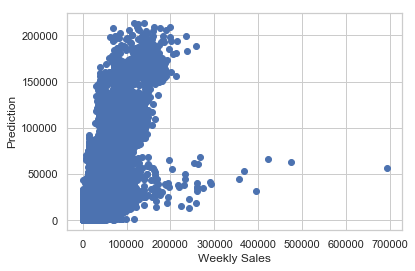

In [68]:
plt.plot(np.exp(tvs_result2.label)-1, np.exp(tvs_result2.prediction)-1, 'bo')
plt.xlabel('Weekly Sales')
plt.ylabel('Prediction')
plt.show()

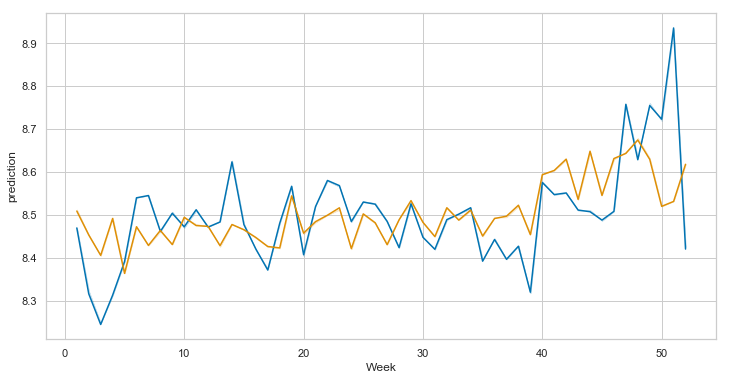

In [67]:
plt.figure(figsize=(12,6))
sns.lineplot(x = "Week", y = "label", data = tvs_result2, ci=False)
sns.lineplot(x = "Week", y = "prediction", data = tvs_result2, ci=False)

#### WMAE for TVS

In [170]:
df_error = tvs_result.select("IsHoliday","label","prediction")

In [171]:
df_error = df_error.withColumn("label",exp("label")-1)
df_error = df_error.withColumn("prediction",exp("prediction")-1)

In [172]:
df_error = df_error.withColumn('weight', when(df_error['IsHoliday'] < 1, 1).otherwise(5))

In [173]:
df_error = df_error.toPandas()

In [174]:
WMAE_LR2 = WMAE(df_error.weight, df_error.label, df_error.prediction)
WMAE_LR2

7467.72

### Generalized Linear Regression

In [89]:
# Load Generalized Linear Regression
GLR_Model = PipelineModel.load("GLR_model")

In [90]:
GLR_prediction = GLR_Model.transform(validate_df)

In [91]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

In [145]:
rmse_GLR = evaluator.evaluate(GLR_prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_GLR)

Root Mean Squared Error (RMSE) on test data = 1.21243


In [93]:
GLR_Predict_train2 = GLR_prediction.select("Week","features","label","prediction").toPandas()

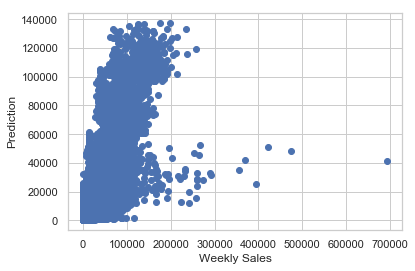

In [95]:
plt.plot(np.exp(GLR_Predict_train2.label)-1, np.exp(GLR_Predict_train2.prediction)-1, 'bo')
plt.xlabel('Weekly Sales')
plt.ylabel('Prediction')
plt.show()

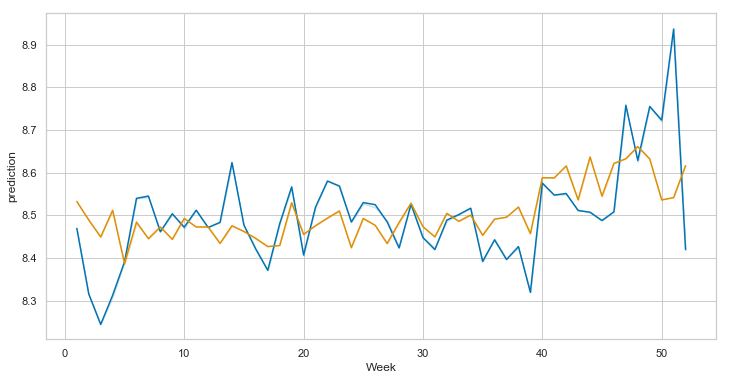

In [94]:
plt.figure(figsize=(12,6))
sns.lineplot(x = "Week", y = "label", data = GLR_Predict_train2, ci=False)
sns.lineplot(x = "Week", y = "prediction", data = GLR_Predict_train2, ci=False)

#### WMAE for Generalized Linear Regression

In [147]:
df_error = GLR_prediction.select("IsHoliday","label","prediction")

In [148]:
df_error = df_error.withColumn("label",exp("label")-1)
df_error = df_error.withColumn("prediction",exp("prediction")-1)

In [149]:
df_error = df_error.withColumn('weight', when(df_error['IsHoliday'] < 1, 1).otherwise(5))

In [150]:
df_error = df_error.toPandas()

In [151]:
WMAE_GLR = WMAE(df_error.weight, df_error.label, df_error.prediction)
WMAE_GLR

6979.29

## Comparing WMAE

In [168]:
WMAE_LR

8411.97

In [175]:
WMAE_LR2

7467.72

In [179]:
WMAE_GLR

6979.29